In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join("..")))

# Geocoding

Unlike the Chicago data, there is very much a discrete set of points to which events are assigned.
- It appears that each "natural section" of the road network is assigned a point; often 2 points, one for each side of the road.
- The code below attempts to "normalise" block names-- there is some variation in spelling.
- Even accounting for this, there appear to be a large number of errors (not large compared to the total event count, but large as in the number of distinct points involved).
   - As for the Chicago data, this means it will be difficult, if not impossible, to assign events to the "correct" block they occurred on.

We could look into re-assigning the events with "nonsense" geo-coding.  Does it matter?  No: it's only 143 events!!

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import tilemapbase
import shapely.geometry
import pyproj
proj = pyproj.Proj({"init":"EPSG:2768"})
import bz2, csv, collections
import open_cp.geometry
open_cp.geometry.configure_gdal()

import opencrimedata.san_francisco as sf

In [3]:
datadir = os.path.join("/media", "disk", "Data")
#datadir = os.path.join("..", "..", "..", "..", "Data")

filename = os.path.join(datadir, "SF_Police_Department_Incidents.csv.bz2")
def gen():
    with bz2.open(filename, "rt", encoding="UTF8") as f:
        yield from sf.load(f)
def rawgen():
    with bz2.open(filename, "rt", encoding="UTF8") as f:
        reader = csv.reader(f)
        yield from reader
        
next(gen())

Row(category='NON-CRIMINAL', description='LOST PROPERTY', datetime=datetime.datetime(2015, 1, 19, 14, 0), block='18TH ST / VALENCIA ST', point=(-122.42158168137, 37.7617007179518), idd='15006027571000', incident='150060275')

## Events with nonsense geocoding

In [4]:
rows = rawgen()
next(rows)
odd_codings = set()
count = 0
for row in rows:
    address = row[8]
    x, y = row[9], row[10]
    xx, yy = float(x), float(y)
    if abs(yy - 90) < 1e-9:
        assert abs(xx + 120.5) < 1e-9
        odd_codings.add(address)
        count += 1
print(count)
odd_codings

143


{'17TH ST / COLLINGWOOD ST',
 '1ST ST / BRANNAN ST',
 '1ST ST / BRYANT ST',
 '3RD ST / ISLAISCREEK ST',
 '3RD ST / JAMES LICK FREEWAY HY',
 '5TH ST / 5THSTNORTH ST',
 '5THSTNORTH ST / EDDY ST',
 '5THSTNORTH ST / ELLIS ST',
 '5THSTNORTH ST / OFARRELL ST',
 '7THSTNORTH ST / MCALLISTER ST',
 'ARGUELLO BL / NORTHRIDGE DR',
 'AUSTIN ST / LARKIN ST',
 'AVENUE OF THE PALMS / EUCLID AV',
 'AVENUE OF THE PALMS / GEARY BL',
 'BRANNAN ST / 1ST ST',
 'BRENHAM PL / WASHINGTON ST',
 'BRYANT ST / SPEAR ST',
 'BUSH ST / STGEORGE AL',
 'CHARLES J BRENHAM PL / CLAY ST',
 'EDDY ST / 5THSTNORTH ST',
 'ELLICK LN / CALIFORNIA ST',
 'ELLIS ST / 5THSTNORTH ST',
 'EUCLID AV / AVENUE OF THE PALMS',
 'FITCH ST / DONNER AV',
 'FLORIDA ST / ALAMEDA ST',
 'FRONT ST / THE EMBARCADERONORTH ST',
 'GEARY BL / AVENUE OF THE PALMS',
 'GENEVA AV / INTERSTATE280 HY',
 'GILMAN AV / FITCH ST',
 'GREENWICH ST / THE EMBARCADERO NORTH ST',
 'I-280 / CESAR CHAVEZ ST',
 'I-280 / PENNSYLVANIA AV',
 'INTERSTATE280 HY / GENEVA AV',


## Collect points by block

For each "block" name, look at all the associated points.  We project and work in Meters from now on.

In [5]:
byadd = collections.defaultdict(list)
for row in gen():
    byadd[row.block].append(proj(*row.point))
byadd_full = {a : collections.Counter(v) for a,v in byadd.items()}
byadd = {a:list(c.keys()) for a,c in byadd_full.items()}

Compute the maximum distance between points for the same block and visualise.

In [6]:
max_dists = {}
for key, value in byadd.items():
    dists = []
    for x1, y1 in value:
        for x2, y2 in value:
            dists.append( (x1-x2)**2 + (y1-y2)**2 )
    max_dists[key] = np.sqrt(max(dists))

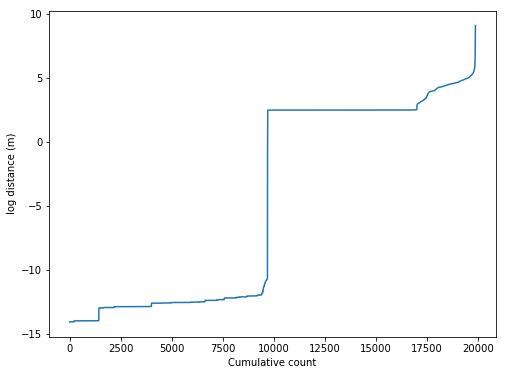

In [7]:
md = list(max_dists.values())
md = np.sort(md)
md = np.log(md[md>0])

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(md)
ax.set(xlabel="Cumulative count", ylabel="log distance (m)")
None

There is a natural gap in distance, firstly for very small distances (about 9cm), and then we note that there are rather few distances between this and about 4.5 meters.

In [8]:
np.max(md[md<-5]), np.min(md[md>=-5])

(-10.609802051354697, -2.4105968383899401)

In [9]:
md[(md>-10) & (md<2)]

array([-2.41059684, -1.91669087, -1.72386947, -1.5084936 , -1.1824012 ,
       -0.44355719,  0.12801147,  0.2859219 ,  0.7131413 ,  0.7616704 ,
        1.14654213,  1.14908581,  1.26710121,  1.50513634])

There are then a very large number of max distances of around 12m

In [10]:
md[md>=2][:20]

array([ 2.00583092,  2.25840873,  2.44208388,  2.48672953,  2.49252872,
        2.49624099,  2.49785902,  2.49786405,  2.49856451,  2.50034231,
        2.5007721 ,  2.50077306,  2.50077323,  2.50077351,  2.50077363,
        2.50077394,  2.50077395,  2.50077397,  2.50077402,  2.50077405])

In [11]:
md[md>=2][6000:6010]

array([ 2.50089302,  2.50089437,  2.50090384,  2.50094393,  2.50096413,
        2.50096771,  2.50096992,  2.50097186,  2.50098137,  2.50100805])

Finally a long tail

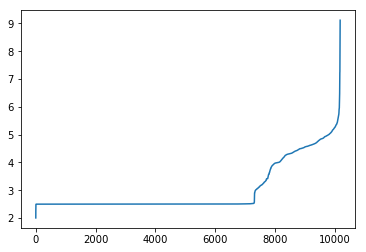

In [12]:
plt.plot(md[(md>2)])

So we end up with three natural classes:
- Points which are, up to essentially numerical error, identical
- Points which are close, mostly around 12m (which seem to be points either side of a road)
- A significant tail of points further apart.

# Visualise cases

In [13]:
def draw_block(points, scale, ax=None):
    xcs, ycs = proj(*np.asarray(list(points)).T, inverse=True)
    xcs, ycs = list(zip(*[tilemapbase.project(x,y) for x,y in zip(xcs, ycs)]))
    xcs = np.asarray(list(xcs))
    ycs = np.asarray(list(ycs))

    xmin, xmax = np.min(xcs), np.max(xcs)
    ymin, ymax = np.min(ycs), np.max(ycs)
    xd, yd = xmax-xmin, ymax-ymin
    xd = max(xd, 1e-5)
    yd = max(yd, 1e-5)
    ex = tilemapbase.Extent(xmin - xd*.2, xmax + xd*.2, ymin - yd*.2, ymax + yd*.2)
    ex = ex.with_scaling(scale)
    ex = ex.to_aspect(1)
    plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)
    if ax is None:
        _, ax = plt.subplots(figsize=(8,8))
    plotter.plot(ax, alpha=0.8)
    ax.scatter(xcs, ycs, marker="x", color="black")
    
tilemapbase.start_logging()

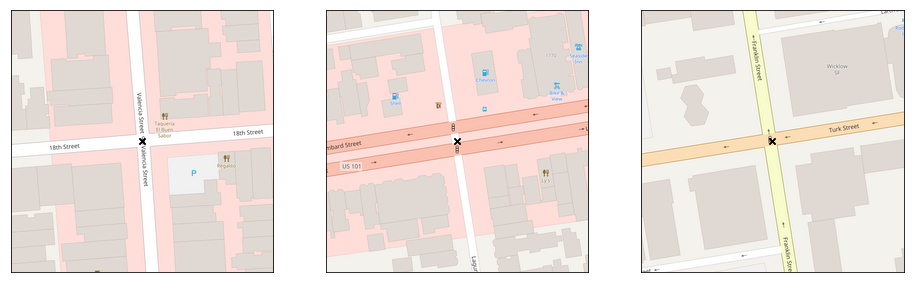

In [15]:
fig, axes = plt.subplots(ncols=3, figsize=(16,7))

small_gaps = (key for key, dist in max_dists.items() if dist < 1)
for ax, key in zip(axes, small_gaps):
    draw_block(byadd[key], 1, ax)
    ax.xaxis.set_visible(False); ax.yaxis.set_visible(False)

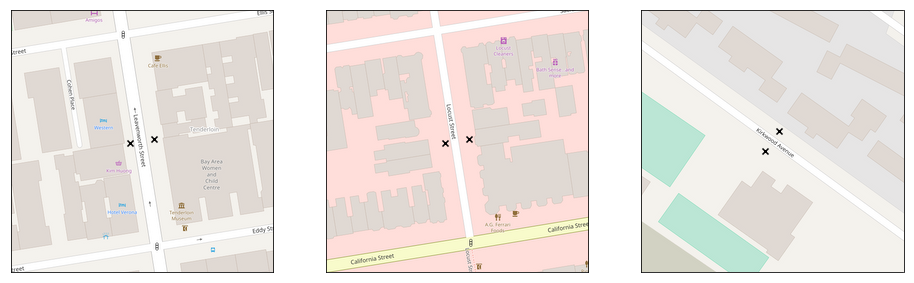

In [16]:
fig, axes = plt.subplots(ncols=3, figsize=(16,7))

mid_gaps = (key for key, dist in max_dists.items() if dist > 10 and dist < 13)
for ax, key in zip(axes, mid_gaps):
    draw_block(byadd[key], 1, ax)
    ax.xaxis.set_visible(False); ax.yaxis.set_visible(False)

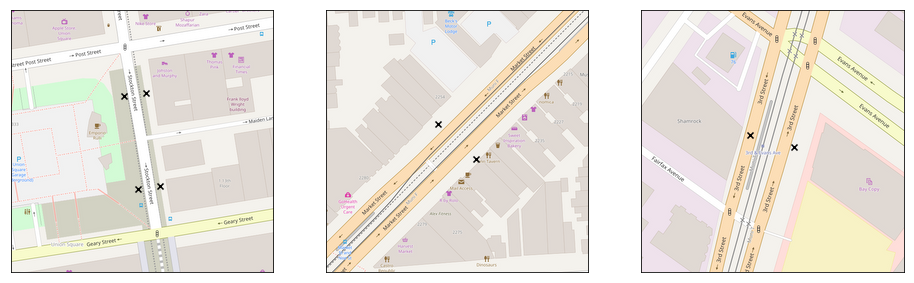

In [17]:
fig, axes = plt.subplots(ncols=3, figsize=(16,7))

large_gaps = (key for key, dist in max_dists.items() if dist > 20)
for ax, key in zip(axes, large_gaps):
    draw_block(byadd[key], 1, ax)
    ax.xaxis.set_visible(False); ax.yaxis.set_visible(False)

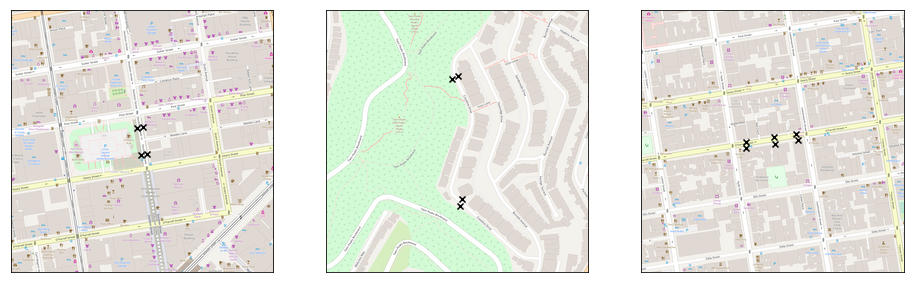

In [18]:
fig, axes = plt.subplots(ncols=3, figsize=(16,7))

large_gaps = (key for key, dist in max_dists.items() if dist > 50)
for ax, key in zip(axes, large_gaps):
    draw_block(byadd[key], 0.3, ax)
    ax.xaxis.set_visible(False); ax.yaxis.set_visible(False)

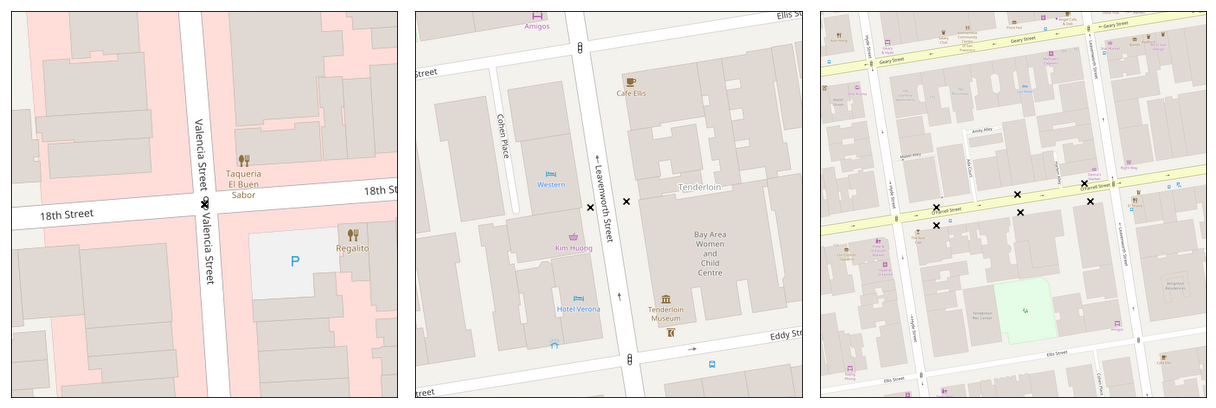

In [19]:
fig, axes = plt.subplots(ncols=3, figsize=(17,8))

small_gaps = list(key for key, dist in max_dists.items() if dist < 1)
mid_gaps = list(key for key, dist in max_dists.items() if dist > 10 and dist < 13)
large_gaps = list(key for key, dist in max_dists.items() if dist > 50)
for ax, key, scale in zip(axes, [small_gaps[0], mid_gaps[0], large_gaps[2]], [1.2,1,0.6]):
    draw_block(byadd[key], scale, ax)
    ax.xaxis.set_visible(False); ax.yaxis.set_visible(False)
fig.tight_layout()

In [20]:
fig.savefig("sf_types.pdf")

## Try to merge `blocks` which are really the same

We have found above that for each unique block ("Address"), we obtain very tightly clustered sets of points.  We now explore the converse of this, looking at each "cluster" and seeing what "Address"es can occur.

- Firstly, the ordering of streets at intersections seems to vary, so we "normalise" to be in alphabetical order
- Then recompute `byadd`

In [21]:
def normalise(add):
    parts = add.split(" / ")
    if len(parts) > 1:
        assert len(parts) == 2
        parts.sort()
        add = " / ".join(parts)
    return add

assert normalise('LOMBARD ST / LAGUNA ST') == 'LAGUNA ST / LOMBARD ST'
assert normalise('LOMBARD ST') == 'LOMBARD ST'

In [64]:
byaddnew = collections.defaultdict(set)
for k,v in byadd.items():
    k = normalise(k)
    for pt in v:
        byaddnew[k].add(pt)
byadd = byaddnew

byadd_full_new = collections.defaultdict(collections.Counter)
for k,v in byadd_full.items():
    k = normalise(k)
    byadd_full_new[k].update(v)
byadd_full = byadd_full_new

**Clustering**

We want to cluster together points which are really close together.  We'll do this by:

- Form a `networkx` graph, each vertex of which is a point, and then connect vertices whose underlying points are really close.  The meaning of "really close" doesn't particularly matter, it turns out.
- Now extract the connected components, each one representing a "merged point"
- We then find the minimum distance between the merged points-- it is larger than the "cutoff" we used, suggesting we've found genuine clusters.

In [31]:
all_points, block_names = [], []
for k, v in byadd.items():
    for pt in v:
        all_points.append(pt)
        block_names.append(k)
all_points = np.asarray(all_points)
all_points.shape

(40377, 2)

In [39]:
import networkx as nx

cutoffsq = 1 # np.exp(-6)
graph = nx.Graph()
for i, pt in enumerate(all_points):
    graph.add_node(i)
idx = np.arange(all_points.shape[0])
for i, pt in enumerate(all_points):
    distsq = np.sum((all_points - pt[None,:])**2, axis=1)
    for j in idx[distsq < cutoffsq]:
        graph.add_edge(i, j)
    if i % 500 == 0:
        print(i, all_points.shape, file=sys.__stdout__)

merged_points = []
for x in nx.connected_components(graph):
    i = list(x)[0]
    merged_points.append(all_points[i])
merged_points = np.asarray(list(merged_points))

In [40]:
min_dist = 10000
for i, pt in enumerate(merged_points[:-1,:]):
    min_for_i = np.min(np.sum((merged_points[i+1:,:] - pt[None,:])**2, axis=1))
    min_dist = min(min_dist, min_for_i)
    if i % 1000 == 0:
        print(i, merged_points.shape, file=sys.__stdout__)
np.log(np.sqrt(min_dist)), np.log(np.sqrt(cutoffsq))

(0.22332662313525442, 0.0)

In [41]:
point_to_blocks = list()
idx = np.arange(all_points.shape[0])
for i, pt in enumerate(merged_points):
    distsq = np.sum((all_points - pt[None,:])**2, axis=1)
    blocks = set(block_names[j] for j in idx[distsq < cutoffsq])
    point_to_blocks.append(blocks)
    if i%500==0:
        print(i, merged_points.shape, file=sys.__stdout__)

We now go down a bit of a rabbit hole, trying to classify repeats...


Want to classify the sets of repeats:
- The same street, just different blocks. E.g. {'400 Block of KIRKWOOD AV', '700 Block of KIRKWOOD AV'}
- Two or more streets intersecting.
- Minor spelling errors.
- What seems like genuine errors.

In [42]:
# pip install pylev  -- Don't use in the end.
#import pylev
import re

def is_different_blocks(keys):
    regex = re.compile("^\d+\s+(.*)$")
    matches = [regex.search(k) for k in keys]
    if any(m is None for m in matches):
        return False
    if len(set(m.group(1) for m in matches)) == 1:
        return True
    return False

assert is_different_blocks({'400 Block of KIRKWOOD AV', '700 Block of KIRKWOOD AV'})
assert not is_different_blocks({'400 Block of KIRKWOOD AV', '700 Block of KIRKWOOD AVE'})

def is_maybe_intersection(keys):
    return all(" / " in k for k in keys)

def is_intersection(keys):
    if not all(" / " in k for k in keys):
        return False
    parts = set(kk for k in keys for kk in k.split(" / "))
    return len(keys) == len(parts) * (len(parts) - 1) / 2

assert is_intersection({'8TH ST / MARKET ST', '8TH ST / HYDE ST', '8TH ST / GROVE ST',
                        'HYDE ST / MARKET ST', 'GROVE ST / HYDE ST', 'GROVE ST / MARKET ST'})
assert not is_intersection({'8TH ST / MARKET ST', '8TH ST / HYDE ST', '8TH ST / GROVE ST',
                        'HYDE ST / MARKET ST', 'GROVE ST / HYDE ST'})

In [139]:
correct_dict = {" VAN NESS " : " VANNESS ",
                " DE BOOM " : " DEBOOM ",
                " SGTJOHNVYOUNG LN" : " SERGEANT JOHN V YOUNG ST",
                " CHARTEROAK " : " CHARTER OAK ",
                " JOHNFKENNEDY " : " JOHN F KENNEDY ",
                " UNITEDNATIONS " : " UNITED NATIONS ",
                " NEWMONTGOMERY " : " NEW MONTGOMERY ",
                " BUENAVISTAEAST " : " BUENA VISTA EAST ",
                " MT VERNON " : " MOUNT VERNON ",
                " VANDYKE " : " VAN DYKE ",
                " EMBARCADERONORTH " : " EMBARCADERO NORTH ",
                " EMBARCADEROSOUTH " : " EMBARCADERO SOUTH ",
                " MIDDLEPOINT " : " MIDDLE POINT ",
                " HENRYADAMS " : " HENRY ADAMS ",
                " NORTHPOINT " : " NORTH POINT ",
                " LA SALLE " : " LASALLE ",
                " DE HARO " : " DEHARO ",
                " POINTLOBOS " : " POINT LOBOS ",
                " NORTHRIDGE DR" : " NORTHRIDGE RD", # Don't believe there is a "Northridge Drive" in San Frandcisco
               }
def correct(k):
    """Correct known spelling mistakes"""
    for f,t in correct_dict.items():
        k = k.replace(f, t)
    return k

byadd_full_normalised = collections.defaultdict(collections.Counter)
for a, v in byadd_full.items():
    byadd_full_normalised[correct(normalise(a))].update(v)

def get_counter(k):
    """Return a counter of points from `byadd_full` having corrected names."""
    return byadd_full_normalised[correct(normalise(k))]

def is_small_count(k):
    """Does address`k` have rather few points?"""
    return sum(get_counter(k).values()) <= 3

known_problems = [{'2ND AV / CABRILLO ST', '22ND AV / CABRILLO ST'},
                 {'DUBOCE AV / OTIS ST', '12TH ST / OTIS ST', '13TH ST / OTIS ST', 'DUBOCE AV / MISSION ST', '13TH ST / DUBOCE AV', '13TH ST / MISSION ST'},
                 {'36TH AV / ANZA ST', '6TH AV / ANZA ST', '26TH AV / ANZA ST'},
                 {'PACIFIC AV / SALMON ST', 'MASON ST / PACIFIC AV'},
                 {'100 Block of NORTHRIDGE RD', '100 Block of NORTHRIDGE DR', '200 Block of NORTHRIDGE RD'},
                 {'100 Block of NORTHRIDGE RD', '100 Block of NORTHRIDGE DR', '200 Block of NORTHRIDGE DR'},
                 {'600 Block of DAVIS ST', '500 Block of DAVIS ST', '100 Block of PACIFIC AV'},
                 {'600 Block of DAVIS ST', '500 Block of DAVIS ST', '0 Block of PACIFIC AV'},
                 {'0 Block of NORTHRIDGE DR', '0 Block of NORTHRIDGE RD'},
                 {'200 Block of THE EMBARCADERO NORTH ST', '300 Block of THE EMBARCADERO SOUTH ST', '200 Block of THE EMBARCADERO SOUTH ST', '400 Block of THE EMBARCADERO SOUTH ST', '400 Block of THE EMBARCADERO NORTH ST', '300 Block of THE EMBARCADERO NORTH ST'},
                 {'200 Block of THE EMBARCADERO NORTH ST', '200 Block of THE EMBARCADERO SOUTH ST', '400 Block of THE EMBARCADERO SOUTH ST', '400 Block of THE EMBARCADERO NORTH ST', '300 Block of THE EMBARCADERO NORTH ST'},
                 {'14TH AV / QUINTARA ST', '48TH AV / QUINTARA ST', '46TH AV / QUINTARA ST'},
                 {'16TH ST / UTAH ST', '18TH ST / UTAH ST', '15TH ST / UTAH ST'},
                 {'900 Block of GREAT HY', '1000 Block of GREAT HY', '1000 Block of UPPER GREAT HY', '1100 Block of GREAT HY'},
                 {'900 Block of GREAT HY', '1000 Block of LA PLAYA ST', '1000 Block of GREAT HY', '1100 Block of GREAT HY'},
                 # This is okay, from Google Maps
                 {'0 Block of WHALESHIP PZ', '400 Block of DAVIS CT'},
                 {'LOMBARD ST / THE EMBARCADERO NORTH ST', 'JEFFERSON ST / POWELL ST', 'POWELL ST / THE EMBARCADERO NORTH ST', 'JEFFERSON ST / THE EMBARCADERO NORTH ST'},
                 {'ASHBURY TR / PIEDMONT ST', 'DELMAR ST / PIEDMONT ST'},
                 {'10TH AV / JOHN F KENNEDY DR', '8TH AV / JOHN F KENNEDY DR', '6TH AV / JOHN F KENNEDY DR', '47TH AV / JOHN F KENNEDY DR', '36TH AV / JOHN F KENNEDY DR', '30TH AV / JOHN F KENNEDY DR'},
                {'37TH AV / VICENTE ST', '17TH AV / VICENTE ST'},
                {'35TH AV / SANTIAGO ST', '30TH AV / SANTIAGO ST', '36TH AV / SANTIAGO ST'},
                  {'7TH AV / FULTON ST', '37TH AV / FULTON ST'},
                  {'12TH AV / KIRKHAM ST', '25TH AV / KIRKHAM ST'},
                  {'CLAY ST / THE EMBARCADERO NORTH ST', 'NORTH POINT ST / THE EMBARCADERO NORTH ST', 'BAY ST / THE EMBARCADERO NORTH ST', 'LOMBARD ST / THE EMBARCADERO NORTH ST'},
                  {'0 Block of THE EMBARCADERO NORTH ST', '0 Block of THE EMBARCADERO SOUTH ST'},
                 ]

for i, choices in enumerate(point_to_blocks):
    choices = set(correct(k) for k in choices)
    for k in list(choices):
        if is_small_count(k):
            choices.remove(k)
    if len(choices) <= 1:
        continue
    if is_different_blocks(choices):
        continue
    if is_intersection(choices):
        continue
    if is_maybe_intersection(choices):
        these_points = set()
        for a,v in byadd.items():
            if correct(normalise(a)) in choices:
                these_points.update(v)
        d = max((x-xx)**2+(y-yy)**2 for x,y in these_points for xx,yy in these_points)
        if d < 1e-6:
            continue
    if choices in known_problems:
        continue
    print(choices)
    break
i, len(point_to_blocks)

{'0 Block of THE EMBARCADERO NORTH ST', '100 Block of THE EMBARCADERO NORTH ST', '100 Block of THE EMBARCADERO SOUTH ST', '0 Block of THE EMBARCADERO SOUTH ST'}


(1543, 30481)

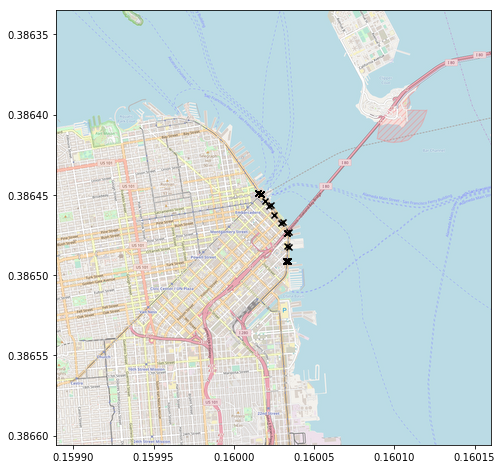

In [140]:
# Visualise the last problem
points = []
for k, v in byadd.items():
    k = correct(k)
    if k in choices:
        points.extend(v)
draw_block(points, .1)

In [141]:
# Display full information
for a,v in byadd_full.items():
    if correct(normalise(a)) in choices:
        print(a, v)

0 Block of THE EMBARCADERONORTH ST Counter({(1833675.1411370693, 644101.1694023737): 452, (1833716.2340370754, 644106.1976023705): 102, (1833699.5668369944, 644394.6920023719): 30, (1833704.9695370484, 644655.1286023633): 8, (1833745.4535370134, 644666.7929023686): 4, (1833297.3298370675, 645289.0662023682): 4, (1833377.4923370369, 645193.6129023694): 3, (1833220.8836370513, 645442.1715023733): 3, (1833599.9359370274, 644854.5978023673): 2, (1833628.5991370156, 644879.6984023651): 2, (1833740.5100370136, 644387.5473023677): 1, (1833405.3671370465, 645210.8978023661): 1})
0 Block of THE EMBARCADEROSOUTH ST Counter({(1833675.1411370693, 644101.1694023737): 1061, (1833704.9695370484, 644655.1286023633): 45, (1833716.2340370754, 644106.1976023705): 26})
100 Block of THE EMBARCADERONORTH ST Counter({(1833148.1907370803, 645446.2162023709): 46, (1833220.8836370513, 645442.1715023733): 29})
100 Block of THE EMBARCADEROSOUTH ST Counter({(1833148.1907370803, 645446.2162023709): 49, (1833220.883

# Save to shapefile

From browsing around the output of the above in QGIS (for example) we find that the above plot is very typical: we find two points either side of the road, and sometimes, the points split up along a street.

In [23]:
blocks = []
geo = []
for key, value in byadd.items():
    for x,y in value:
        blocks.append(key)
        geo.append(shapely.geometry.Point(x,y))
frame = gpd.GeoDataFrame({"block":blocks})
frame.geometry = geo
frame.crs = {"init":"EPSG:2768"}
frame.to_file("SF_All_Locations")